In [1]:
import integration
import coordinates
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

In [2]:
def accel_schwarzschild(x,v,GM):
    """
    Calculates the ?proper acceleration? time is in units of c, meaning c = 1
    for the schwarzschild metric
    
    x = [t,r,phi]
    v = [dt/dtau, dr/dtau, dphi/dtau]
    returns [d^2t/dtau^2, d^2r/dtau^2, d^2phi/dtau^2]
    """
    a = np.zeros(3)
    if x[1] < 2*GM:
        return a
    rm2GM = x[1]-2*GM
    a[0] = -2*GM/(x[1]*rm2GM) * v[1] * v[0]
    a[1] -= GM/x[1]**3 * rm2GM * v[0]**2
    a[1] += GM/(x[1]*rm2GM) * v[1]**2
    a[1] += rm2GM*v[2]**2
    a[2] = -2/x[1]*v[2]*v[1]
    return a

def accel_lense_thirring(x,v,GM):
    """
    Calculates the ?proper acceleration? time is in units of c, meaning c = 1
    for the lense-thirring effect
    
    x = [t,r,phi]
    v = [dt/dtau, dr/dtau, dphi/dtau]
    returns [d^2t/dtau^2, d^2r/dtau^2, d^2phi/dtau^2]
    """
    a = np.zeros(3)
    if x[1] < 2*GM:
        return a
    a[0] = 0
    
    return a

In [3]:
def get_geodesic(x0,v0,dtau,tau_max,acc_func,GM,max_r):
    """
    Calculates a geodesic starting at x0 with v0 with stepsize dtau until reaching tau_max using 4th order Runge-Kutta
    """
    def dgl(t,z):
        a = acc_func(z[:3],z[3:],GM)
        return np.concatenate([z[3:],a])
    z0 = np.concatenate([x0,v0])
    taus = [0]
    zs = [z0]
    for i in range(int(tau_max/dtau)):
        taus.append(taus[-1]+dtau)
        if zs[-1][1]+zs[-1][4]*dtau > 2*GM*1.01 and zs[-1][1] <= max_r:
            zn = integration.RK_step(taus[-1], zs[-1], dtau, dgl, integration.bt_RK4)
            zs.append(zn)
        else:
            zs.append(zs[-1])
    zs = np.array(zs).T
    rs = coordinates.conv_coords([zs[1],zs[2],np.zeros_like(zs[0])], "cylindrical", "cartesian")[:2]
    return (np.array(taus),rs[0],rs[1])

In [4]:
def get_points_on_gridlines(fR, tR, N, count):
    pnts = []
    dr = (np.array(tR)-np.array(fR))/np.array(N)
    ys = np.linspace(fR[1],tR[1],N[1]*count)
    for xi in range(N[0]+1):
        xs = np.ones(N[1]*count)*(fR[0]+xi*dr[0])
        #pnts = np.append(pnts, [xs, ys], axis=1)
        pnts.append([xs,ys])
    xs = np.linspace(fR[0],tR[0],N[0]*count)
    for yi in range(N[1]+1):
        ys = np.ones(N[0]*count)*(fR[1]+yi*dr[1])
        #pnts = np.append(pnts, [xs, ys], axis=1)
        pnts.append([xs,ys])
    return np.array(pnts)

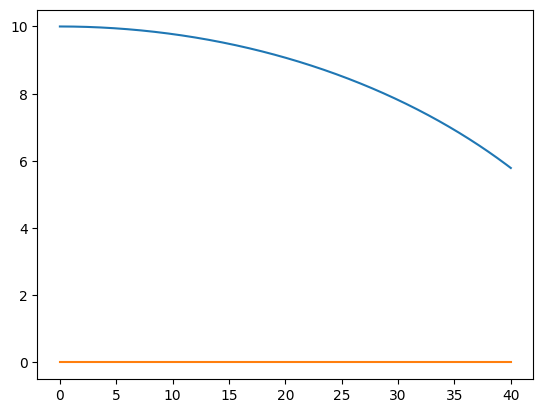

In [5]:
taus, xs,ys = get_geodesic([0, 10.0, 0], [1.0, 0, 0], 0.1, 40.0, accel_schwarzschild, 0.5, 10.0)
plt.plot(taus, xs)
plt.plot(taus, ys)
plt.show()

In [6]:
pnts = get_points_on_gridlines([-12.0,-12.0],[12.0,12.0],[16,16],4)
for li in range(len(pnts)):
    pnts[li] = coordinates.conv_coords([pnts[li,0],pnts[li,1],np.zeros_like(pnts[li,0])], "cartesian", "cylindrical")[:2]
tau_max = 40.0

lines = []
taus = []
for li in range(len(pnts)):
    lines.append([])
    for i in range(len(pnts[li,0])):
        taus, xs,ys = get_geodesic([0, pnts[li,0,i], pnts[li,1,i]], [1.0, 0, 0], tau_max/200, tau_max, accel_schwarzschild, 0.5, 12.0)
        lines[-1].append([xs,ys])
lines = np.array(lines)
print(lines.shape)

(34, 64, 2, 201)


In [7]:
%matplotlib inline

tNs = lines.shape[3]
plot_title = "spacetime visualization"

plt.rcParams["animation.html"] = "jshtml"
#plt.rcParams['figure.dpi'] = 100
matplotlib.rcParams['animation.embed_limit'] = 2**32
plt.ioff()

fig, ax = plt.subplots(1,figsize=(5,5),dpi=100)
#fig.tight_layout(w_pad=0,h_pad=0)

def animate(t):
    #plt.cla()
    ax.cla()
    for li in range(len(lines)):
        ax.plot(lines[li,:,0,t],lines[li,:,1,t],zorder=-1)
        #ax.scatter(lines[li,:,0,t],lines[li,:,1,t],color='grey',marker='.',zorder=-1)
    ax.add_patch(plt.Circle((0, 0), 1.0, color='k'))
    ax.set_aspect(1)
    ax.set_xlim(-5.1,5.1)
    ax.set_ylim(-5.1,5.1)
    fig.suptitle(plot_title+f' t={taus[t]:0.2f}')
    #print(f'{t+1}/{tNs}')
fanim = matplotlib.animation.FuncAnimation(fig, animate, frames=range(0,tNs,int(tNs/50)))

In [8]:
fanim

In [9]:
import ctypes
import json
library = ctypes.cdll.LoadLibrary('../go/rkf45.so')

In [10]:
init = library.InitSchwarzschild
init.argtypes = [ctypes.c_char_p]
dostep = library.DoStepSchwarzschild
getstate = library.GetStateSchwarzschild
getstate.restype = ctypes.c_void_p

init_params = {
    "dtau0":1e-8,
    "err":1e-8,
    "GM":1.0,
    "t0":0.0,
    "r0":10.0,
    "phi0":0.0,
    "dtdtau0":1.0,
    "drdtau0":0.0,
    "dphidtau0":0.0
}

init(json.dumps(init_params).encode('utf-8'))

state = json.loads(ctypes.string_at(getstate()))
print(state)

{'phi': 0, 'r': 10, 't': 0, 'tau': 0}


2025/02/13 22:20:23 &{0x7f0938234ae0 6 10 1.0000000000000001e-16 1e-08 0 0 [0 10 0 1 0 0] [[0 0 0 0 0 0] [0 0 0 0 0 0] [0 0 0 0 0 0] [0 0 0 0 0 0] [0 0 0 0 0 0] [0 0 0 0 0 0]]}
